In [81]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

### Cleaning of General Data

In [82]:
# Set research-based constants
scc = 51 # $51 damages are caused per ton of CO2 emissions

# Import electricity generation data
elec_gen = pd.read_csv('raw/electric_gen.csv')
emissions = pd.read_csv('raw/co2_emissions_from_energy_consumption.csv')
elec_cost = pd.read_csv('raw/electric_cost.csv')

# Only keep desired rows
elec_gen = elec_gen[elec_gen.Column_Order == 9]
emissions = emissions[emissions.Column_Order == 14]
elec_cost = elec_cost[elec_cost.Column_Order == 6]

# Only keep rows with valid dates
elec_gen["YYYYMM"] = elec_gen.apply(lambda row : str(row["YYYYMM"]), axis=1)
elec_gen = elec_gen[elec_gen["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

emissions["YYYYMM"] = emissions.apply(lambda row : str(row["YYYYMM"]), axis=1)
emissions = emissions[emissions["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

elec_cost["YYYYMM"] = elec_cost.apply(lambda row : str(row["YYYYMM"]), axis=1)
elec_cost = elec_cost[elec_cost["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

# Convert string to date
elec_gen["Date"] = elec_gen.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)
emissions["Date"] = emissions.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)
elec_cost["Date"] = elec_cost.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)

# Drop unneeded columns
elec_gen.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)
emissions.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)
elec_cost.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)

# Drop NaN values
elec_cost = elec_cost[pd.to_numeric(elec_cost["Value"], errors="coerce").notnull()]

# Drop values from before 2000 (no cryptocurrencies invented until 2008)
starttime = datetime(2000, 1, 1)
elec_gen = elec_gen[elec_gen["Date"] > starttime]
emissions = emissions[emissions["Date"] > starttime]
elec_cost = elec_cost[elec_cost["Date"] > starttime]

# Convert values to KWh, Metric Tons of CO2, and Dollars per KWh, respectively
elec_gen["Gen [KWh]"] = elec_gen.apply(lambda row : (float(row["Value"]) * 1000000000), axis=1)
emissions["Emissions [Metric Tons CO2]"] = emissions.apply(lambda row : (float(row["Value"]) * 1000000), axis=1)
elec_cost["Cost [USD per KWh]"] = elec_cost.apply(lambda row : (float(row["Value"]) / 100), axis=1)

elec_gen.reset_index(inplace=True)
emissions.reset_index(inplace=True)
elec_cost.reset_index(inplace=True)

/tmp/ipykernel_77551/416357028.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  elec_gen = elec_gen[elec_gen["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]
/tmp/ipykernel_77551/416357028.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  emissions = emissions[emissions["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]
/tmp/ipykernel_77551/416357028.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  elec_cost = elec_cost[elec_cost["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]


In [83]:
# Calculate emissions per KWh of energy produced
elec_emissions = pd.DataFrame()
elec_emissions["Energy Emissions (Metric Tons CO2 / KWh)"] = emissions["Emissions [Metric Tons CO2]"] / elec_gen["Gen [KWh]"]
elec_emissions["Date"] = emissions["Date"]

### Visualizations of General Data

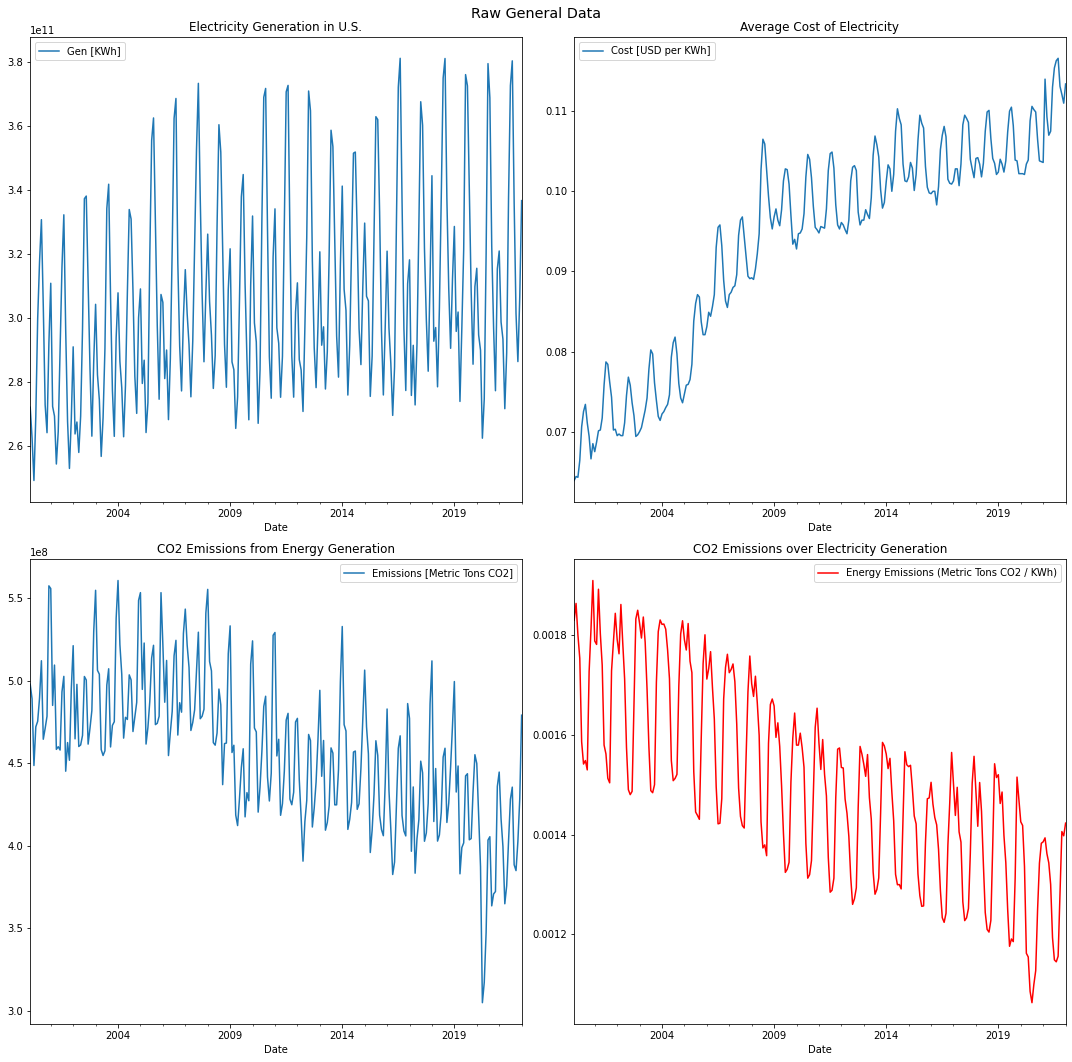

In [84]:
# Visualizations of raw general data
fig, axes = plt.subplots(2, 2, figsize=(15,15))
plt.suptitle("Raw General Data", size='x-large')
elec_gen.plot(ax=axes[0, 0], x="Date", y="Gen [KWh]", kind="line", title="Electricity Generation in U.S.")
emissions.plot(ax=axes[1, 0],x="Date", y="Emissions [Metric Tons CO2]", kind="line", title="CO2 Emissions from Energy Generation")
elec_cost.plot(ax=axes[0, 1],x="Date", y="Cost [USD per KWh]", kind="line", title="Average Cost of Electricity")
elec_emissions.plot(ax=axes[1, 1], x="Date", y="Energy Emissions (Metric Tons CO2 / KWh)", kind="line", title="CO2 Emissions over Electricity Generation", color="red")
fig.tight_layout()
plt.show()

### Cleaning of Coins Pricing Data

In [85]:
# Import data for each coin
nano = pd.read_csv("raw/xno_pricing.csv")
cardano = pd.read_csv("raw/ada_pricing.csv")
algorand = pd.read_csv("raw/algo_pricing.csv")
solana = pd.read_csv("raw/sol_pricing.csv")
hedera = pd.read_csv("raw/hbar_pricing.csv")

# Set names
nano.name="Nano"
cardano.name="Cardano"
algorand.name="Algorand"
solana.name="Solana"
hedera.name="Hedera"

coins_dfs = [nano, cardano, algorand, solana, hedera]

# Clean each dataframe
for index, coin in enumerate(coins_dfs):
    # Convert string to date
    coin["Date"] = coin.apply(lambda row: datetime.strptime(
        str(row["snapped_at"]).strip(), "%Y-%m-%d %H:%M:%S %Z"), axis=1)
    
    # Rename column
    coin["Price (USD)"] = coin["price"]

    # We are interested in price per coin, not market cap or volume
    coin.drop(["snapped_at", "price", "market_cap", "total_volume"], axis=1, inplace=True)

    # We want coin pricing per month
    newDf = coin.resample('M', on="Date").mean().reset_index()
    coin["Price (USD)"] = newDf["Price (USD)"]
    coin["Date"] = newDf["Date"]
    coin.dropna(inplace=True)

### Visualizations of Coin Pricing Data

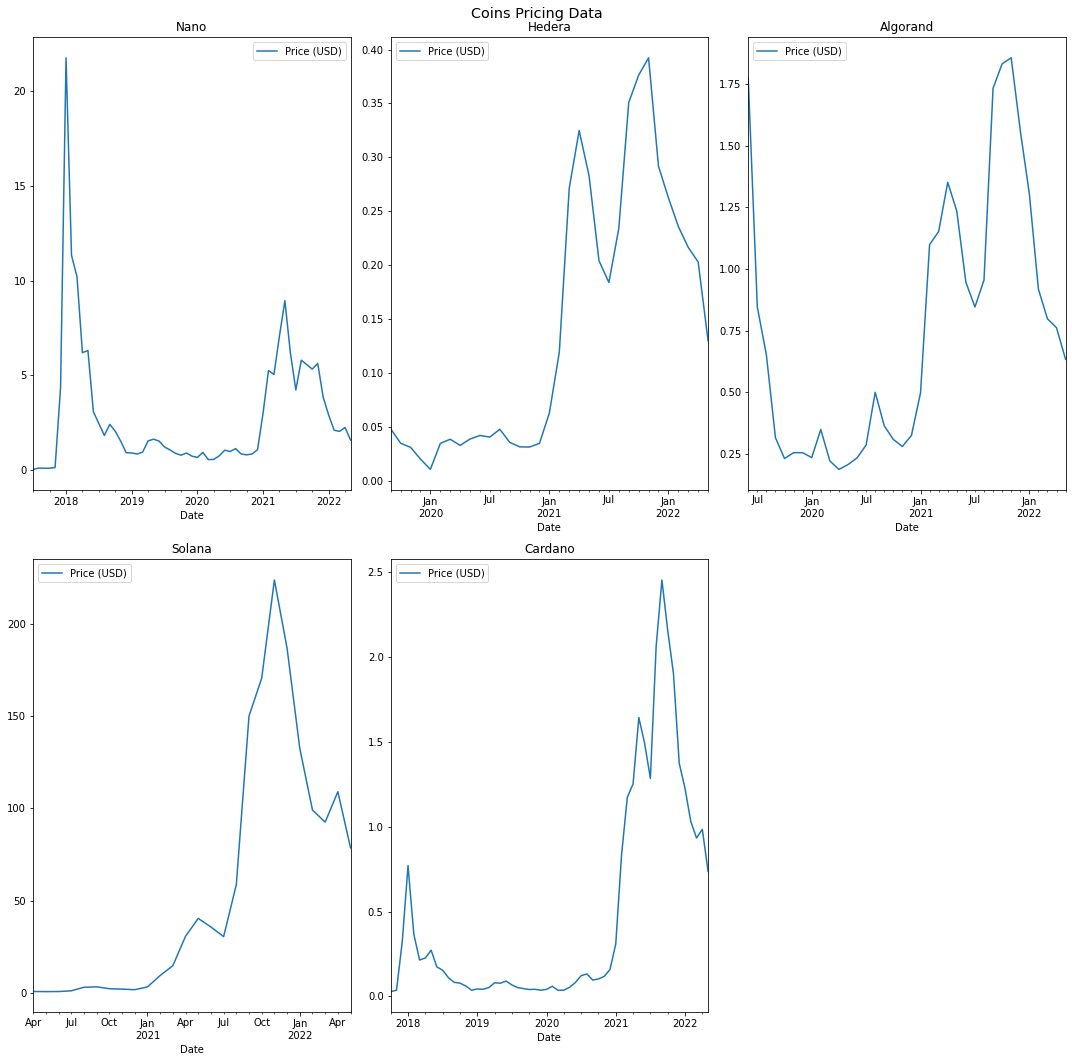

In [86]:
# Visualizations of coins pricing data
fig, axes = plt.subplots(2, 3, figsize=(15,15))
plt.suptitle("Coins Pricing Data", size='x-large')
for index, coin in enumerate(coins_dfs):
    coin.plot(ax=axes[index % 2, index % 3], x="Date", y="Price (USD)", kind="line", title=coin.name)
axes[1, 2].set_visible(False)
fig.tight_layout()
plt.show()

### Prepare Coins Energy Data

In [87]:
# GOALS IN THIS CELL - 
#   Set kwh_per_tx for each coin (energy in kwh used per transaction)
#   Set tx_per_day for each coin (transactions performed per day)
#   Set kwh_per_day for each coin (energy in kwh used per day)

# Nano
nano.kwh_per_tx = 0.000112
nano.tx_per_day = 80000

# Cardano
cardano.tx_per_day = 100000
cardano.kwh_per_tx = 0.5479

# Algorand
algorand.kwh_per_tx = 0.0000008
algorand.tx_per_day = 500000

# Solana
solana.kwh_per_tx = 0.000752
solana.tx_per_year = 20000000000
solana.tx_per_day = solana.tx_per_year / 365

# Hedera
hedera.kwh_per_tx = 0.00017
hedera.tx_per_day = 1093587

# Compute energy usage per day
for coin in coins_dfs:
    coin.kwh_per_day = coin.kwh_per_tx * coin.tx_per_day

In [88]:
for coin in coins_dfs:
    print("Name: {} \t kWh per day: {}".format(coin.name, coin.kwh_per_day))

Name: Nano 	 kWh per day: 8.959999999999999
Name: Cardano 	 kWh per day: 54790.00000000001
Name: Algorand 	 kWh per day: 0.39999999999999997
Name: Solana 	 kWh per day: 41205.479452054795
Name: Hedera 	 kWh per day: 185.90979000000002


### Calculate cost of energy per transaction for each coin

In [89]:
for coin in coins_dfs:
    merged = pd.merge_asof(coin, elec_cost, on="Date")
    merged.drop("index", axis=1)
    coin["Cost per Transaction (USD)"] = coin.kwh_per_tx * merged["Cost [USD per KWh]"]
    coin.avg_cost_per_tx = np.mean(coin["Cost per Transaction (USD)"])

### Visualizations for Cost per Transaction

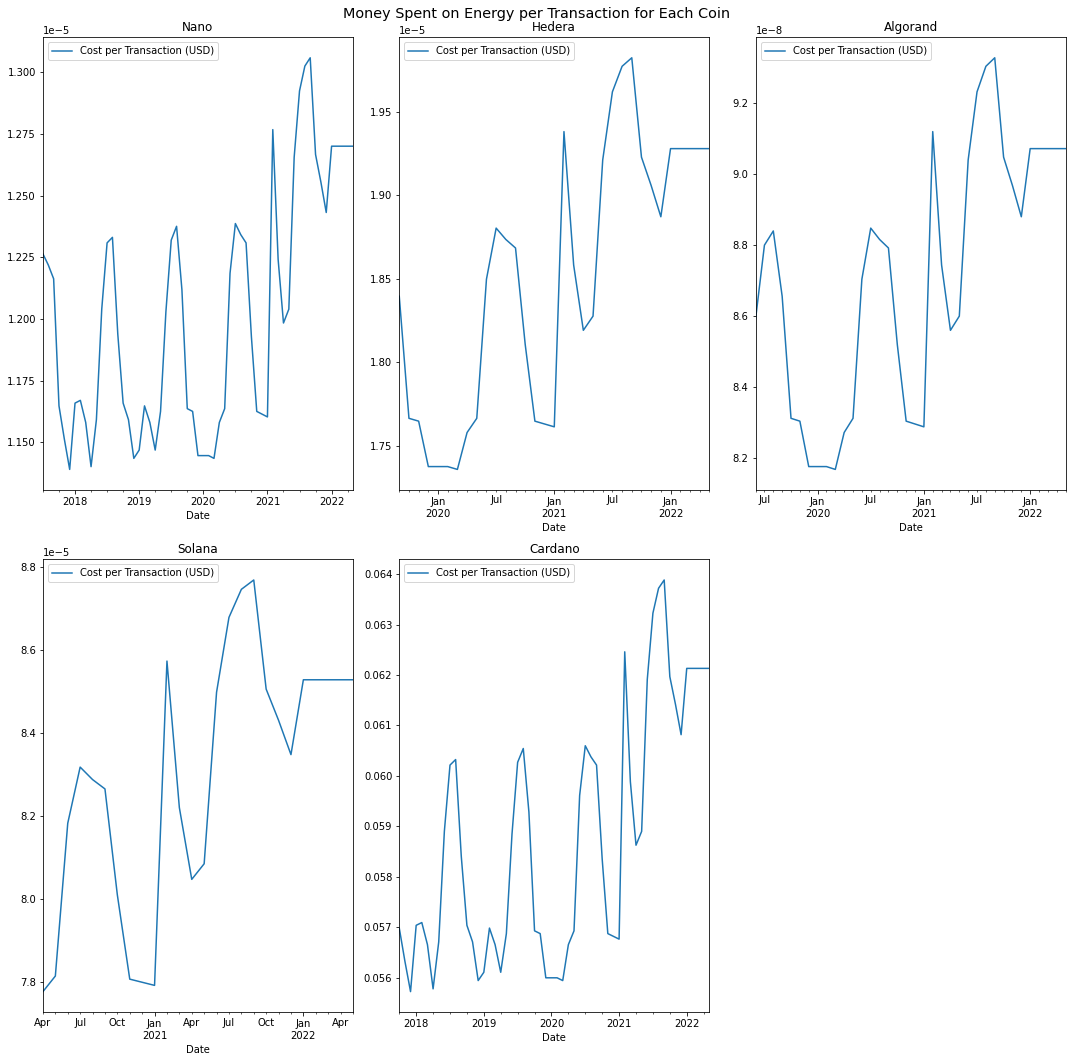

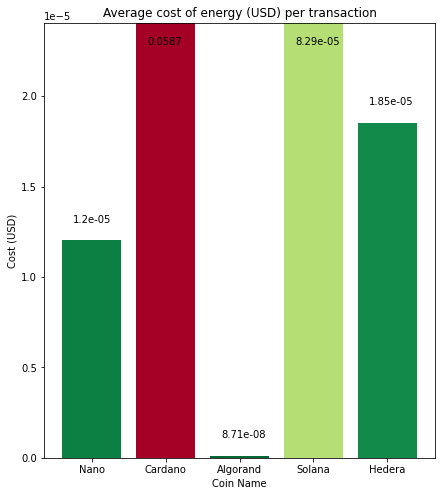

In [90]:
# Visualizations of coins cost data
fig, axes = plt.subplots(2, 3, figsize=(15,15))
plt.suptitle("Money Spent on Energy per Transaction for Each Coin", size='x-large')
for index, coin in enumerate(coins_dfs):
    coin.plot(ax=axes[index % 2, index % 3], x="Date", y="Cost per Transaction (USD)", kind="line", title=coin.name)
axes[1, 2].set_visible(False)
fig.tight_layout()
plt.show()


# Bar plot for averages
plt.figure(figsize=(7, 8))
coin_names = []
costs = []
for index, coin in enumerate(coins_dfs):
    coin_names.append(coin.name)
    costs.append(coin.avg_cost_per_tx)

cmap = cm.RdYlGn.reversed()
norm = Normalize(vmin=0, vmax=0.00025)
colors = []
for index, coin in enumerate(coins_dfs):
    colors.append(cmap(norm(coin.avg_cost_per_tx)))
    plt.text(index - 0.25, min([coin.avg_cost_per_tx + 0.000001, np.median(costs) * 1.3 * 0.95]), f'{coin.avg_cost_per_tx:.3g}')
plt.bar(coin_names, costs, color=colors)
plt.title("Average cost of energy (USD) per transaction")
plt.xlabel("Coin Name")
plt.ylabel("Cost (USD)")
plt.ylim(0, np.median(costs) * 1.3)
plt.show()

### Calculate carbon emissions per transaction

In [91]:
for coin in coins_dfs:
    merged = pd.merge_asof(coin, elec_emissions, on="Date")
    coin["Emissions per Transaction (Metric Tons CO2)"] = coin.kwh_per_tx * merged["Energy Emissions (Metric Tons CO2 / KWh)"]
    coin.avg_emissions_per_tx = np.mean(coin["Emissions per Transaction (Metric Tons CO2)"])

### Visualizations for carbon emissions per transaction

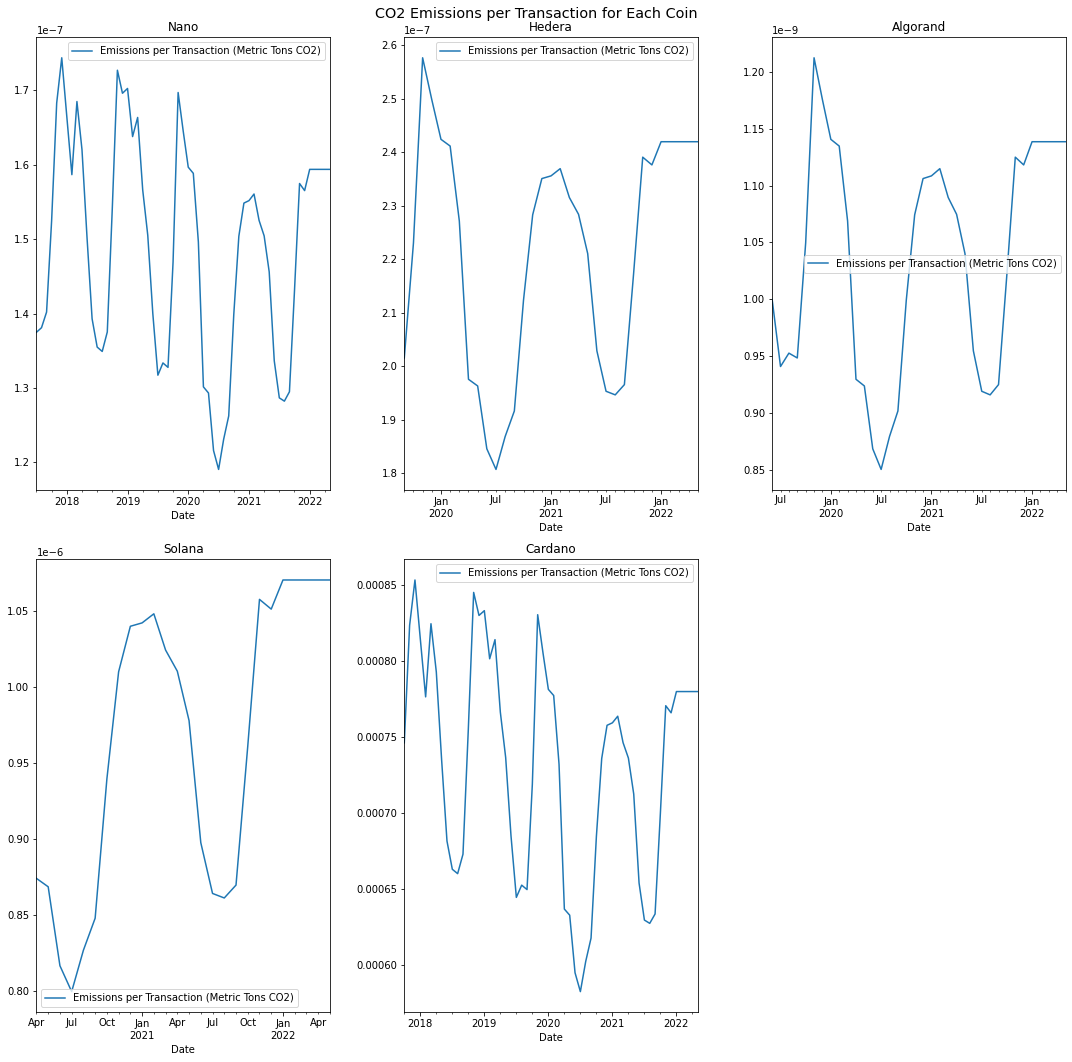

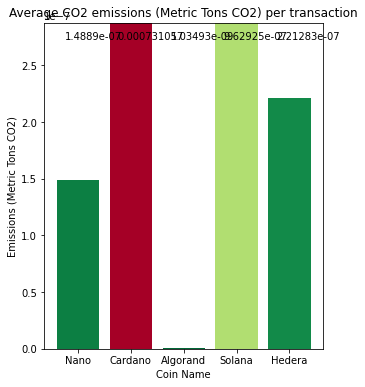

In [106]:
# Visualizations of coins emissions data
fig, axes = plt.subplots(2, 3, figsize=(15,15))
plt.suptitle("CO2 Emissions per Transaction for Each Coin", size='x-large')
for index, coin in enumerate(coins_dfs):
    coin.plot(ax=axes[index % 2, index % 3], x="Date", y="Emissions per Transaction (Metric Tons CO2)", kind="line", title=coin.name)
axes[1, 2].set_visible(False)
fig.tight_layout()
plt.show()

# Bar plot for averages
plt.figure(figsize=(5, 6))
coin_names = []
emission_vals = []
for index, coin in enumerate(coins_dfs):
    coin_names.append(coin.name)
    emission_vals.append(coin.avg_emissions_per_tx)

cmap = cm.RdYlGn.reversed()
norm = Normalize(vmin=0, vmax=0.000003)
colors = []
for index, coin in enumerate(coins_dfs):
    colors.append(cmap(norm(coin.avg_emissions_per_tx)))
    plt.text(index - 0.25, min([coin.avg_emissions_per_tx + 0.01, np.median(emission_vals) * 1.3 * 0.95]), f'{coin.avg_emissions_per_tx:.6g}')
plt.bar(coin_names, emission_vals, color=colors)
plt.title("Average CO2 emissions (Metric Tons CO2) per transaction")
plt.xlabel("Coin Name")
plt.ylabel("Emissions (Metric Tons CO2)")
plt.ylim(0, np.median(emission_vals) * 1.3)
plt.show()

### Compute climate damages (externalities)

In [93]:
for coin in coins_dfs:
    coin["Climate Damages (USD)"] = scc * coin["Emissions per Transaction (Metric Tons CO2)"]

### Compute net social value
Net social value of transaction = coin price - (electricity price * electricity per transaction) - damages per transaction

In [94]:
for coin in coins_dfs:
    print(coin["Climate Damages (USD)"])
    coin["Net Social Value (USD)"] = coin["Price (USD)"] - coin["Cost per Transaction (USD)"] - coin["Climate Damages (USD)"]

0     0.000007
1     0.000007
2     0.000007
3     0.000008
4     0.000009
5     0.000009
6     0.000008
7     0.000008
8     0.000009
9     0.000008
10    0.000008
11    0.000007
12    0.000007
13    0.000007
14    0.000007
15    0.000008
16    0.000009
17    0.000009
18    0.000009
19    0.000008
20    0.000008
21    0.000008
22    0.000008
23    0.000007
24    0.000007
25    0.000007
26    0.000007
27    0.000007
28    0.000009
29    0.000008
30    0.000008
31    0.000008
32    0.000008
33    0.000007
34    0.000007
35    0.000006
36    0.000006
37    0.000006
38    0.000006
39    0.000007
40    0.000008
41    0.000008
42    0.000008
43    0.000008
44    0.000008
45    0.000008
46    0.000007
47    0.000007
48    0.000007
49    0.000007
50    0.000007
51    0.000007
52    0.000008
53    0.000008
54    0.000008
55    0.000008
56    0.000008
57    0.000008
58    0.000008
Name: Climate Damages (USD), dtype: float64
0     0.038048
1     0.041991
2     0.043508
3     0.041536
4     0.039

### Visualizations for net social value

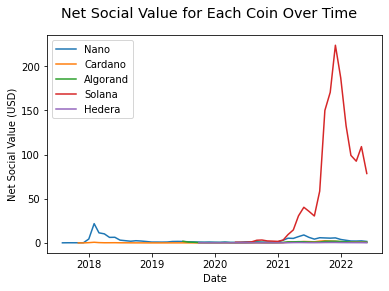

In [117]:
# Visualizations of coins emissions data
plt.suptitle("Net Social Value for Each Coin Over Time", size='x-large')
for index, coin in enumerate(coins_dfs):
    plt.plot(coin["Date"], coin["Net Social Value (USD)"], label=coin.name)
plt.legend()
plt.ylabel("Net Social Value (USD)")
plt.xlabel("Date")
plt.show()